# double_integral_bandpass.py
the double_integral_bandpass module is used to calculate the height of a smartfin ride through double integral analysis. It takes in processed imu heights and runs a double integral analysis on the data and calculates the mean height. 

The goal is to find the method which gives us the smallest error when a scalar is applied. Regardless of the size of the scalar, the smaller the error is, the more consistent the fin is in its measurements. If the error is 0, then we know our method of calculating heights is as consistent as a CDIP buoy. 

POSSIBLE FUTURE TESTS:
- pick rides that have vastly different heights to see if smartfin is consistent with changes in height
- pick rides that are all from the same area / rides that are all from different areas

In [1]:
from smartfin_ride_module import RideModule
from double_integral_bandpass import double_integral_bandpass_filter
import pandas as pd
import requests 
from io import StringIO
from scatter_plot import smartfin_plot # scatter plot module compares CDIP and Smartfin heights

# initialize ride module
ride = RideModule()

# intitalize height analysis module
filt = double_integral_bandpass_filter()

# get all CDIP buoys
buoyListQuery = f'http://127.0.0.1:8000/ride/buoy-list'
buoys = requests.get(buoyListQuery).json()

ride initialized


In [2]:
# get list of ride ids
# url = 'https://raw.githubusercontent.com/UCSD-E4E/Smartfin/master/Ben%20Experiments/2017%20Ride%20IDs.csv' #2017 data
url = 'https://raw.githubusercontent.com/UCSD-E4E/Smartfin/master/Ben%20Experiments/Ride_IDs_2019.csv' #2019 data
Ride_ID = pd.read_csv(url)
ride_ids = Ride_ID['Ride Number'].values.tolist()
ride_ids = ride_ids[:]
# really strange rides, figure out how to remove automatically
ride_ids[28]
del(ride_ids[28])

## functions

In [3]:
"""
get the raw motion dataframes and CDIP_heights from smartfin ride api 
"""
def query_ride_api(ride_ids):
    for ride in ride_ids:
        rideCreate = f'http://127.0.0.1:8000/ride/ride-create/{ride}' # creates new ride and upload all ride data to db
        response = requests.get(rideCreate)
        data = response.json()
        if len(data) <= 1: 
            print('found bad ride')
            continue
        mdf_str = StringIO(data['motionData'])
        mdf = pd.read_csv(mdf_str)
        mdfs.append(mdf)
        CDIP_heights.append(data['heightCDIP'])
        
    return mdfs, CDIP_heights

In [65]:
import numpy as np
import random

def filter_data(mdf):
    
    mean = mdf['IMU A2'].mean()
    std = mdf['IMU A2'].std()
    Upperbound = mean+(2*std)
    Lowerbound = mean-(2*std)
    Up = (mean+.5)
    Low = (mean-.5)
    og_mdf = len(mdf)
#     print('mean is: ' + str(mean))
#     print('std. dev. is: ' + str(std))
#     print('Upperbound is: ' + str(Upperbound))
#     print('Lowerbound is: ' + str(Lowerbound))
    mdf.loc[mdf['IMU A2'] > Upperbound, 'IMU A2'] = float(random.uniform(Up, Low))
    mdf.loc[mdf['IMU A2'] < Lowerbound, 'IMU A2'] = float(random.uniform(Up, Low))
#     print(df['IMU A2'].min())

    points_deleted = og_mdf - len(mdf)
    print(f'points deleted: {points_deleted}')
    return mdf
   

def filter_chunks(accs, times):
     # find threshold for chunk values
    means = []

    for chunk in accs:
        mean = chunk.mean()
        means.append(mean)

    chunk_mean = np.mean(means)
    chunk_std = np.std(means) * 2

    # find the indices of the bad chunks
    bad_chunk_indices = []

    for i in range(len(means)):
        if abs(chunk_mean - means[i]) > chunk_std:
            bad_chunk_indices.append(i)
            
    og_accs = len(accs)

    # rebuild acceleration chunk array without values from bad chunks
    accs = [i for j, i in enumerate(accs) if j not in bad_chunk_indices]
    times = [i for j, i in enumerate(times) if j not in bad_chunk_indices]
    chunks_deleted = og_accs - len(accs)
    print(f'chunks deleted: {chunks_deleted}')
        
    return accs, times

"""
get chunks from dataframe and filters bad chunks out of filter keyword arg is true
"""
def process_motion_data(mdf, f_chunks, f_data):
    
    if f_data: 
        mdf = filter_data(mdf)
    
    # get data chunks
    accs, times, chunk_len = filt.chunk_data(mdf['IMU A2'], mdf['Time'])
    
    if f_chunks: 
        accs, times = filter_chunks(accs, times)

    return accs, times, chunk_len

In [66]:
"""
get heights of smartfin and cdip buoys of a single smartfin ride
"""
def get_heights(mdfs, buoys, filter_chunks=False, filter_data=False):
    
    filt = double_integral_bandpass_filter()
    displacements = []
    CDIP_heights = []
    c = 0 
    for mdf in mdfs:
        mdf_len = len(mdf)
        mdf_quarter = mdf_len / 4
        mdf_half = mdf_quarter * 2
        mdf = mdf[int(mdf_quarter):int(mdf_half)]
        accs, times, chunk_len = process_motion_data(mdf, filter_chunks, filter_data)
        d, ds = (filt.get_displacement_data(accs, times))
        displacements.append(d)
#         print(c)
        c += 1
    
    return displacements

In [67]:
"""
calibrates the scalar to minimize error between smartfin and cdip heights (or any other heights were trying to match)
"""
def calculate_scalar(smartfin_h, CDIP_h):
    
    scalar = 1
    min_error = 10000000
    
    smartfin_h = np.array(smartfin_h)
    CDIP_h = np.array(CDIP_h)
    
    # calculate scalar to nearest whole number
    for i in range(1, 10):
        
        # calculate error of multiplying by current scalar
        heights = smartfin_h * i
        error = abs((1 - (CDIP_h/heights)) *100)
        error = np.mean(error)
        
        # if current scalar yields smaller error than min_error
        if error < min_error:
            scalar = i
            min_error = error
#             print(f'scalar: {scalar}')
#             print(f'error: {min_error}')
            
    # calculate scalar to nearest thousandth
    for i in range(0, 1000):
        hundredth = i / 1000
        temp_scalar = scalar + hundredth
        heights = smartfin_h * temp_scalar
        error = abs((1 - (CDIP_h/heights)) *100)
        error = np.mean(error)
#         print(f'scalar: {temp_scalar}')
#         print(f'error: {error}')
        if error < min_error:
            scalar = temp_scalar
            min_error = error
#             print(f'MIN scalar: {scalar}')
#             print(f'MIN error: {min_error}')
          
    return scalar

## main variables

In [68]:
mdfs = []
CDIP_heights = []
mdfs, CDIP_heights = query_ride_api(ride_ids)
print(len(mdfs))

81


## Base case: smartfin accuraccy without filtering chunks or data
use this case to compare against

In [69]:
# scatter_plot code without the filtering
displacements = get_heights(mdfs, buoys)

scalar: 3.405999999999999
intialized


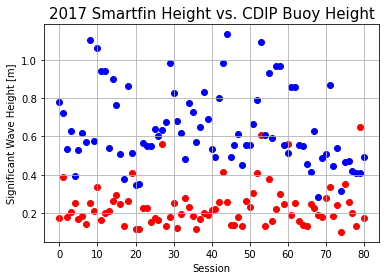

mean error is 62.85980609812359%


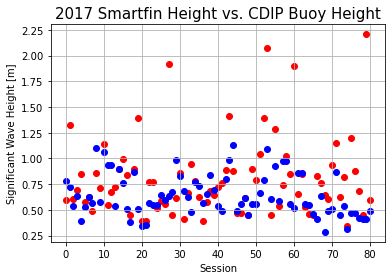

mean error is 26.93308687034573%


In [70]:
scalar = calculate_scalar(displacements, CDIP_heights)
print(f'scalar: {scalar}')
plot = smartfin_plot()
plot.scatter_plot(displacements, CDIP_heights, scalar)

## option 1: filter chunks without filtering data

calculate heights without bad chunks

In [71]:
displacements = get_heights(mdfs, buoys, filter_chunks=True)

chunks deleted: 4
chunks deleted: 2
chunks deleted: 2
chunks deleted: 2
chunks deleted: 6
chunks deleted: 6
chunks deleted: 3
chunks deleted: 4
chunks deleted: 4
chunks deleted: 4
chunks deleted: 7
chunks deleted: 4
chunks deleted: 5
chunks deleted: 4
chunks deleted: 8
chunks deleted: 11
chunks deleted: 7
chunks deleted: 9
chunks deleted: 3
chunks deleted: 2
chunks deleted: 9
chunks deleted: 6
chunks deleted: 8
chunks deleted: 11
chunks deleted: 11
chunks deleted: 2
chunks deleted: 2
chunks deleted: 2
chunks deleted: 3
chunks deleted: 3
chunks deleted: 1
chunks deleted: 3
chunks deleted: 3
chunks deleted: 3
chunks deleted: 6
chunks deleted: 6
chunks deleted: 3
chunks deleted: 4
chunks deleted: 4
chunks deleted: 3
chunks deleted: 4
chunks deleted: 6
chunks deleted: 5
chunks deleted: 2
chunks deleted: 2
chunks deleted: 4
chunks deleted: 6
chunks deleted: 4
chunks deleted: 2
chunks deleted: 5
chunks deleted: 7
chunks deleted: 4
chunks deleted: 9
chunks deleted: 2
chunks deleted: 11
chunks

scalar: 4
intialized


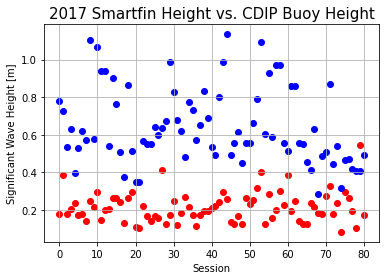

mean error is 65.17492712083855%


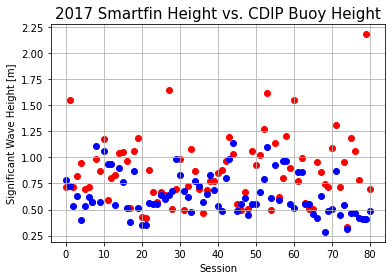

mean error is 27.27097275312057%


In [72]:
scalar = calculate_scalar(displacements, CDIP_heights)
print(f'scalar: {scalar}')
plot = smartfin_plot()
plot.scatter_plot(displacements, CDIP_heights, scalar)

## option 2 filter data but not chunks

In [73]:
displacements = get_heights(mdfs, buoys, filter_data=True)

points deleted: 0
points deleted: 0


C:\Users\evans\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points deleted: 0
points del

scalar: 4
intialized


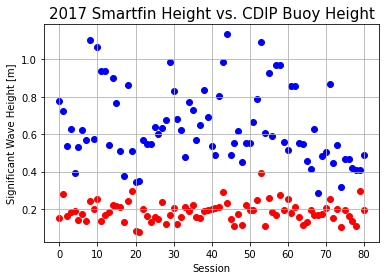

mean error is 69.42253242299108%


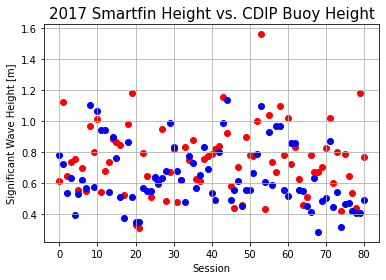

mean error is 23.218817152025313%


In [74]:
scalar = calculate_scalar(displacements, CDIP_heights)
print(f'scalar: {scalar}')
plot = smartfin_plot()
plot.scatter_plot(displacements, CDIP_heights, scalar)

## option 3: filter both data and chunks (expected to be the best method)

In [75]:
displacements = get_heights(mdfs, buoys, filter_chunks=True, filter_data=True)

points deleted: 0
chunks deleted: 2
points deleted: 0
chunks deleted: 2
points deleted: 0
chunks deleted: 2
points deleted: 0
chunks deleted: 4
points deleted: 0
chunks deleted: 7
points deleted: 0
chunks deleted: 3
points deleted: 0
chunks deleted: 2
points deleted: 0
chunks deleted: 2
points deleted: 0
chunks deleted: 4
points deleted: 0
chunks deleted: 1
points deleted: 0
chunks deleted: 4
points deleted: 0
chunks deleted: 2
points deleted: 0
chunks deleted: 3
points deleted: 0
chunks deleted: 6
points deleted: 0
chunks deleted: 3
points deleted: 0
chunks deleted: 9
points deleted: 0
chunks deleted: 6
points deleted: 0
chunks deleted: 12
points deleted: 0
chunks deleted: 4
points deleted: 0
chunks deleted: 10
points deleted: 0
chunks deleted: 6
points deleted: 0
chunks deleted: 3
points deleted: 0
chunks deleted: 8
points deleted: 0
chunks deleted: 7
points deleted: 0
chunks deleted: 5
points deleted: 0
chunks deleted: 4
points deleted: 0
chunks deleted: 3
points deleted: 0
chunks d

scalar: 4.066
intialized


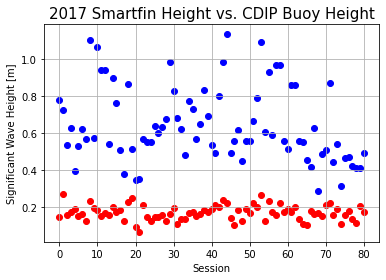

mean error is 71.96852292727125%


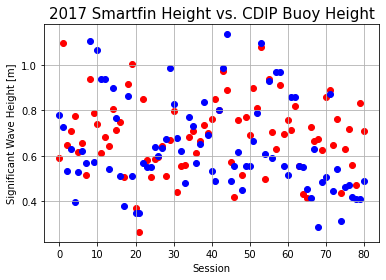

mean error is 21.159906333360187%


In [76]:
scalar = calculate_scalar(displacements, CDIP_heights)
print(f'scalar: {scalar}')
plot = smartfin_plot()
plot.scatter_plot(displacements, CDIP_heights, scalar)